# Analyse RF-Data
Perform QUS evaluations on preprocessed data (Data/sorted_elastography/*recording*/...rf_no_tgc.npy)

#### Perform stFFT on Files without TGC
- safe stFFT under ...rf.stfft.npy 
- isn't used right now, because I had to change the calculations for the attenuation-correlations (stFFT is now calculated further down and not safed)

### Define parameters 
- which data to use
- which parameters to use for the stFFT
- which parameters to use for the QUS evaluation
- load phantom data and perform stFFT on it

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/jakobschaefer/Documents/rf-ultrasound')  # necessary to import functions from other directory
import functions.definitions as definitions
import yaml 
import shutil
import math
from scipy import stats
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm  
import copy
from sklearn.metrics import r2_score
import functions.def_notion_API as notion_def
from notion_client import Client
from datetime import date

In [ ]:
# create directory and copy all files with tgc for C3 and L15 to it
version = '230330'
start_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version
end_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/C3_and_L15_without_TGC_'+version

filter_autogain_off = True

# create directory
if not os.path.exists(end_directory):
    os.makedirs(end_directory)
 
    # copy files
    for dir in tqdm(os.listdir(start_directory)):
        C3_no_tgc = False
        L15_no_tgc = False
        # for loop through all recordings:
        for file in os.listdir(start_directory+'/'+dir):
            if not filter_autogain_off:
                if 'C3_large.rf_no_tgc' in file:
                    C3_no_tgc = True
                if 'L15_large.rf_no_tgc' in file:
                    L15_no_tgc = True
            elif filter_autogain_off:
                if 'C3_large.rf.tgc' in file:
                    C3_no_tgc = True
                if 'L15_large.rf.tgc' in file:
                    L15_no_tgc = True
        if C3_no_tgc and L15_no_tgc:
            if not os.path.exists(end_directory+'/'+dir):
                os.makedirs(end_directory+'/'+dir)
            for file in os.listdir(start_directory+'/'+dir):
                if 'C3_large.rf_no_tgc' in file:
                    shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'/'+file)
                    # copy yaml file
                    shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.yaml', end_directory+'/'+dir+'/'+file[:-11]+'.yaml')
                if 'L15_large.rf_no_tgc' in file:
                    shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'/'+file)
                    # copy yaml file
                    shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.yaml', end_directory+'/'+dir+'/'+file[:-11]+'.yaml')

In [6]:
#  define directory (on SSH to save storage space)
version = '230330'
start_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/C3_and_L15_without_TGC_'+version


transducer = 'C3' # choose C3_large, L15_large or combined
tgc = 'no_tgc'
ref_parameter = 'CAP' # choose CAP or Median_E

window_function = 'hamming' # hanning, hamming, blackman or none

# define Notion IDs 
safe_to_notion = True

notion_token_230808 = 'secret_gkAXWxlfrzEhCvOVRoBOk0BpVP4nKhfp4nb1y4cW13y'
results_page_id = '92597b4e6b714ba9ad85adabd908e3a3'
results_database_id = '5d836d0ca4354f4485f4ea8d10b047f9'

if transducer == 'L15':
    # min_depth = 687
    # max_depth = 2704
    # start_scanline = 0
    # number_of_scanlines = 192
    window_size = 100
    hop_size = 1#

    # frequency non-specific
    min_depth = 640
    max_depth = 2546
    start_scanline = 0
    number_of_scanlines = 192
if transducer == 'L15' and version == '230726': #based on bayesian optimization (not frequency-specific!)
    min_depth = 629
    max_depth = 2704
    start_scanline = 0
    number_of_scanlines = 192
    window_size = 218
    hop_size = 1
    window_function = 'blackman'
if transducer == 'C3':
    min_depth = 196
    max_depth = 2320
    start_scanline = 57
    number_of_scanlines = 94
    window_size = 100
    hop_size = 3

    # frequency non-specific
    # min_depth = 505
    # max_depth = 2184
    # start_scanline = 0
    # number_of_scanlines = 192

end_scanline = start_scanline + number_of_scanlines

if transducer == 'combined1':
    window_size = 50
    hop_size = 2

# define notion properties
notion_transducer=  transducer
notion_cropping_properties  = str('Min. depth: '+str(min_depth)+'\nMax. depth: '+str(max_depth)+'\nStart scanline: '+str(start_scanline)+'\nEnd scanline: '+str(end_scanline))
notion_window_func = str('Window function: '+str(window_function)+'\nWindow size: '+str(window_size)+'\nHop size: '+str(hop_size))


# get results out of RedCap-Survey (csv)
dir_redcap_survey = '/Users/jakobschaefer/Documents/REDCap_Survey_'+version+'.csv'

# calculations:
# calculate stFFT of phantom for normalization
# load phantom recording
try: 
    phantom_array = np.load('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Calibration/Phantom/'+transducer+'_large.rf_no_tgc.npy')
    # get sampling rate
    if transducer == 'C3':
        fs = 15e6
    if transducer == 'L15':
        fs = 30e6
    if transducer == 'combined1':
        fs = 30e6
    # shorten array axially
    phantom_array = phantom_array[:,min_depth:max_depth,:]
    # shorten array laterally
    phantom_array = phantom_array[start_scanline:end_scanline,:,:]
    # get stFFT of phantom
    phantom_stfft = definitions.stFFT(phantom_array, window_size, hop_size, fs, window_function)

    # remove dot-underscore files (they are created when copying files from/to SSH)
    definitions.remove_dot_underscore_files(start_directory)
    for dir in tqdm(os.listdir(start_directory)):
        definitions.remove_dot_underscore_files(start_directory+'/'+dir)
except:
    print('Phantom recording not found. Please check if the SSD is connected.')

Phantom recording not found. Please check if the SSD is connected.


In [ ]:
# Correlation between CAP and Median_E
# get redcap values out of csv file
Patient_ID, Median_E, Median_CAP, IQR_E, IQR_CAP, scan_conditions = definitions.get_fibroscan_values(dir_redcap_survey)

Median_CAP = np.array(Median_CAP)
Median_E = np.array(Median_E)


slope, intercept, r, p, std_err = stats.linregress(Median_CAP, Median_E)

#spearman coefficient?

def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, Median_CAP))

print('Pearson correlation coefficient: ', r)
print('Pearson p-value: ', p)

# plot correlation
plt.figure()
plt.scatter(Median_CAP, Median_E)
plt.plot(Median_CAP, mymodel, color = 'orange')
plt.xlabel('Median CAP')
plt.ylabel('Median E')
plt.title('Correlation between Median CAP and Median E')
plt.show()

In [ ]:
# FFT of specific file
# choose specific file
patient = 'UKD152'

# load file
array = np.load(start_directory+'/'+patient+'/'+transducer+'_large.rf_no_tgc.npy')

# get sampling rate out of yaml file
if transducer == 'C3':
    yaml_file = start_directory+'/'+dir+'/'+transducer+'_large.rf.yaml'
    sampling_rate, fs, t = definitions.read_yaml_file(yaml_file, array)
else:
    yaml_file = start_directory+'/'+dir+'/'+'L15'+'_large.rf.yaml'
    sampling_rate, fs, t = definitions.read_yaml_file(yaml_file, array)

# perform FFT on first scanline in first frame
x_fft,y_fft = definitions.amplitude_spectrum(fs, array[0,:,0], window_function)

# normalization with phantom array
# get phantom array
phantom_array = np.load('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Phantom/'+transducer+'_large.rf_no_tgc.npy')
# perform FFT on first scanline in first frame
x_fft_phantom,y_fft_phantom = definitions.amplitude_spectrum(fs, phantom_array[0,:,0], window_function)


# rescale x_fft to MHz
x_fft = x_fft/1e6
x_fft_phantom = x_fft_phantom/1e6

# plot FFT
plt.figure()
plt.plot(x_fft,y_fft, label = 'Patient')
plt.plot(x_fft_phantom,y_fft_phantom, label = 'Phantom')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude')
plt.title('FFT '+patient+'_'+transducer)
plt.legend()
plt.show()


# divide fft by fft of phantom
y_fft = y_fft/y_fft_phantom

# plot FFT
plt.figure()
plt.plot(x_fft,y_fft, label = 'Patient/Phantom')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude')
plt.title('FFT '+patient+'_'+transducer)
plt.legend()
plt.show()


### Calculate attenuation and correlate with fibroscan values

In [ ]:
# calculate attenuation and store in list
# get redcap values out of csv file
Patient_ID, Median_E, Median_CAP, IQR_E, IQR_CAP, scan_conditions = definitions.get_fibroscan_values(dir_redcap_survey)

redcap_value = []
pearson_per_frequency = []
slopes_all_recordings = []
for dir in tqdm(os.listdir(start_directory)):
    # for loop through all recordings:
    for file in os.listdir(start_directory+'/'+dir):
        if transducer in file and tgc in file:
            # get array without tgc from this recording
            array = np.load(start_directory+'/'+dir+'/'+file)

            # skip arrays with less pixels than max_depth
            array_too_short = False
            if len(array[0,:,0]) < max_depth:
                array_too_short = True
                break

            # get redcap value out of lists from csv file
            number_redcap_value = Patient_ID.index(dir) 
            #choose from which list to get redcap values
            if ref_parameter == 'Median_E':
                list_values = Median_E
            else: 
                list_values = Median_CAP
            redcap_value.append(list_values[number_redcap_value])
                
            # apply min- and max_depth
            array = array[:,min_depth:max_depth,:]

            #remove the sides from array 
            array = array[start_scanline:end_scanline,:,:]

            # apply log to data (to perform linear regression)
            array = np.log10(np.abs(array)+1e-10)

            # remove nan and inf values
            array = np.nan_to_num(array)

            # extract just the first frame of the array (change later on?)
            array = array[:,:,0]
            
            slopes_per_recording = []
            for scanline in range(len(array)):

                one_scanline = array[scanline,:]
                # get slope 
                slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(one_scanline)), one_scanline)
                slopes_per_recording.append(slope)
            slopes_all_recordings.append(slopes_per_recording)
    
slopes_all_recordings = np.array(slopes_all_recordings) 

# get mean slope per recording
mean_slopes_all_recordings = []
for recording in range(len(slopes_all_recordings)):
    mean_slopes_all_recordings.append(np.mean(slopes_all_recordings[recording]))

# get abs value from slopes 
mean_slopes_all_recordings = mean_slopes_all_recordings

In [ ]:
# safe results of mean slopes and redcap values in AI directory
target_dict = {}
for key in Patient_ID:
    for value in redcap_value:
        target_dict[key] = value
        redcap_value.remove(value)
        break

# safe mean slopes and redcap values in AI directory
input_data_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data'
target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets' 
np.save(input_data_directory+'/mean_slopes_all_recordings_'+transducer+'_'+version, mean_slopes_all_recordings)
np.save(target_directory+'/targets_'+ref_parameter+'_'+transducer+'_'+version, target_dict)

In [17]:
transducer = 'L15'

Pearson correlation coefficient:  0.6944045692112996
Pearson p-value:  1.8843588037327725e-20
Mean slope:  0.0023330864400925395
std slope:  0.00043474330900606837


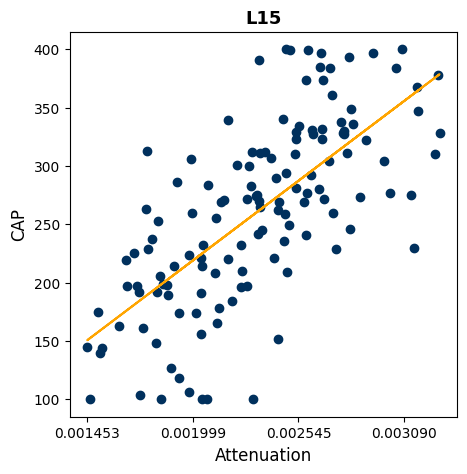

In [18]:
# plot results
data_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data'
target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets'

mean_slopes_all_recordings = np.load(data_directory+'/mean_slopes_all_recordings_'+transducer+'_'+version+'.npy')
target_dict = np.load(target_directory+'/targets_CAP_'+transducer+'_'+version+'.npy', allow_pickle='TRUE')

redcap_value = list(target_dict.item().values())

mean_slopes_all_recordings = np.abs(mean_slopes_all_recordings)

slope, intercept, r, p, std_err = stats.linregress(mean_slopes_all_recordings,redcap_value)

def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc,mean_slopes_all_recordings))

print('Pearson correlation coefficient: ', r)
print('Pearson p-value: ', p)
print('Mean slope: ', np.mean(mean_slopes_all_recordings))
print('std slope: ', np.std(mean_slopes_all_recordings))

plt.figure(figsize=(5, 5))
plt.scatter(mean_slopes_all_recordings,redcap_value, color = '#00305D')
plt.plot( mean_slopes_all_recordings,mymodel, color = 'orange')
plt.ylabel(ref_parameter, fontsize = 12)
plt.xlabel('Attenuation', fontsize = 12)
plt.xticks(np.arange(mean_slopes_all_recordings.min(), mean_slopes_all_recordings.max(), mean_slopes_all_recordings.max()/6))
plt.title(transducer, fontweight = 'bold',fontsize = 13)#'Correlation between CAP value and rf-based attenuation')
plt.show()

# safe to notion
notion_evaluation_parameter = 'normal Attenuation Parameter' 
notion_results = str('Pearson coef.: '+str(round(r, 3))+ '\n(p-value: '+ str(round(p, 3))+')')
notion_version = str(version+'\n('+str(len(mean_slopes_all_recordings))+' Pat.)')
notion_def.safe_to_notion_def(notion_version, notion_evaluation_parameter, notion_results, notion_transducer, notion_cropping_properties,notion_window_func, safe_to_notion, results_database_id)

In [19]:
# perform spearman correlation
rho, p = stats.spearmanr(mean_slopes_all_recordings,redcap_value)

print('Spearman correlation coefficient: ', rho)
print('Spearman p-value: ', p)


Spearman correlation coefficient:  0.7232304336247046
Spearman p-value:  8.308271949351088e-23


In [ ]:
# polynomial regression
mean_slopes_all_recordings = np.abs(mean_slopes_all_recordings)

model = np.polyfit(mean_slopes_all_recordings, redcap_value, 1)
predict = np.poly1d(model)
x_lin_reg = np.linspace(np.min(mean_slopes_all_recordings), np.max(mean_slopes_all_recordings), 100)
y_lin_reg = predict(x_lin_reg)

r_squared = r2_score(redcap_value, predict(mean_slopes_all_recordings))
r = np.sqrt(r_squared)
print('R^2: ', r_squared)
print('R: ', r)
plt.figure()
plt.scatter(mean_slopes_all_recordings,redcap_value, color = '#00305D')
plt.plot(x_lin_reg, y_lin_reg, color = 'orange')
plt.xlabel('RF-based attenuation')
plt.ylabel(ref_parameter)
plt.title('Correlation between CAP value and RF-based attenuation')
plt.show()

### Combine L15 and C3 recordings

In [ ]:
# method 1
# reduce both transducers in time domain to same length, FFT, adding zeros, IFFT, adding up

for dir in tqdm(os.listdir(start_directory)):
    # for loop through all recordings:
    for file in os.listdir(start_directory+'/'+dir):
        if tgc in file:
            #load files
            C3_recording = np.load(start_directory+'/'+dir+'/C3_large.rf_no_tgc.npy')
            L15_recording = np.load(start_directory+'/'+dir+'/L15_large.rf_no_tgc.npy')

            # read in metadata from yaml file
            yaml_file_C3 = start_directory+'/'+dir+'/C3_large.rf.yaml'
            sampling_rate_C3, fs_C3, t_C3 = definitions.read_yaml_file(yaml_file_C3, C3_recording)

            yaml_file_L15 = start_directory+'/'+dir+'/L15_large.rf.yaml'
            sampling_rate_L15, fs_L15, t_L15 = definitions.read_yaml_file(yaml_file_L15, L15_recording)

            # reduce C3 frames to L15 frames
            C3_recording = C3_recording[:,:,:len(L15_recording[0,0,:])]
            # reduce L15 frames to C3 frames
            L15_recording = L15_recording[:,:,:len(C3_recording[0,0,:])]

            # bring both recording to same length 
            quotient_sampling_rate = sampling_rate_L15/sampling_rate_C3
            C3_recording = C3_recording[:,:int(len(L15_recording[0,:,0])/int(quotient_sampling_rate)),:]

            #'''
            # get FFT of both recordings
            C3_recording_fft = np.fft.fft(C3_recording, axis = 1)
            L15_recording_fft = np.fft.fft(L15_recording, axis = 1)

            # add zeros to C3 recording
            len_difference_fft = len(L15_recording_fft[0,:,0]) - len(C3_recording_fft[0,:,0])
            C3_recording_fft_with_zeros = np.concatenate((C3_recording_fft[:,:len(C3_recording_fft[0,:,0])//2,:], np.zeros((len(C3_recording_fft[:,0,0]),len_difference_fft, len(C3_recording_fft[0,0,:])),dtype = complex), C3_recording_fft[:,len(C3_recording_fft[0,:,0])//2:,:]), axis = 1)
            #C3_recording_fft_with_zeros = np.concatenate((np.zeros((len(C3_recording_fft[:,0,0]),len_difference_fft//2, len(C3_recording_fft[0,0,:])),dtype = complex), C3_recording_fft, np.zeros((len(C3_recording_fft[:,0,0]),len_difference_fft//2, len(C3_recording_fft[0,0,:])),dtype = complex)), axis = 1)

            # add up both recordings
            combined_recording_fft = C3_recording_fft_with_zeros + L15_recording_fft

            # get IFFT of combined recording
            combined_recording = np.fft.ifft(combined_recording_fft, axis = 1)
            '''
            # adapting the sampling rate of C3 recording to L15 recording via linear interpolation 
            # you cannot do it this way for a 3d array (just with 3 for loops)
            C3_upsampled = np.interp(np.arange(0, len(C3_recording[0,:,0]), 0.5), np.arange(0, len(C3_recording[0,:,0])), C3_recording[0,:,0])

            combined_recording = C3_upsampled + L15_recording[0,:,0]
            '''

            # save combined recording
            np.save(start_directory+'/'+dir+'/combined1_large.rf_no_tgc.npy', combined_recording)

In [ ]:
# method 2 (combining in stFFT)

# get redcap values out of csv file
Patient_ID, Median_E, Median_CAP, IQR_E, IQR_CAP = definitions.get_fibroscan_values(dir_redcap_survey)

redcap_value = []
stfft_all_recordings_combined = []
shape_last_recording = 0
removed_recordings = 0
for dir in tqdm(os.listdir(start_directory)):
    #load files
    C3_recording = np.load(start_directory+'/'+dir+'/C3_large.rf_no_tgc.npy')
    L15_recording = np.load(start_directory+'/'+dir+'/L15_large.rf_no_tgc.npy')

    # read in metadata from yaml file
    yaml_file_C3 = start_directory+'/'+dir+'/C3_large.rf.yaml'
    sampling_rate_C3, fs_C3, t_C3 = definitions.read_yaml_file(yaml_file_C3, C3_recording)

    yaml_file_L15 = start_directory+'/'+dir+'/L15_large.rf.yaml'
    sampling_rate_L15, fs_L15, t_L15 = definitions.read_yaml_file(yaml_file_L15, L15_recording)

    if not len(L15_recording[0,:,0]) < max_depth:

        # # apply min- and max_depth
        # C3_recording = C3_recording[:,min_depth:max_depth,:]
        # L15_recording = L15_recording[:,min_depth:max_depth,:]

        #remove the sides from array 
        C3_recording = C3_recording[start_scanline:end_scanline,:,:]
        L15_recording = L15_recording[start_scanline:end_scanline,:,:]

        # reduce C3 frames to L15 frames
        C3_recording = C3_recording[:,:,:len(L15_recording[0,0,:])]
        # reduce L15 frames to C3 frames
        L15_recording = L15_recording[:,:,:len(C3_recording[0,0,:])]

        # bring both recording to same length 
        quotient_sampling_rate = sampling_rate_L15/sampling_rate_C3
        C3_recording = C3_recording[:,:int(len(L15_recording[0,:,0])/int(quotient_sampling_rate)),:]

        # get redcap value out of lists from csv file
        number_redcap_value = Patient_ID.index(dir) 
        #choose from which list to get redcap values
        if ref_parameter == 'Median_E':
            list_values = Median_E
        else: 
            list_values = Median_CAP
        redcap_value.append(list_values[number_redcap_value])
            
        # get stFFT of both recordings
        window_size_C3 = window_size
        window_size_L15 = int(window_size*quotient_sampling_rate)
        hop_size_C3 = round(window_size_C3//hop_size)
        hop_size_L15 = round(window_size_L15//hop_size)

        # add loop over all frames later on
        stft_array_all_scanlines_combined = []

        for j in range(len(C3_recording[:,0,0])): # loop over all scanlines

            C3_x_array = C3_recording[j,:,0]  # signal recording -> frame info = 0 -> should be changed later on
            try:
                L15_x_array = L15_recording[j,:,0]  # signal recording -> frame info = 0 -> should be changed later on
            except:
                c =1
            stft_array_one_scanline_combined = []

            #stFFT for C3 recording
            for i in range(0,round(len(C3_x_array)/hop_size_C3)):

                segment_array_C3 = C3_x_array[i*hop_size_C3:i*hop_size_C3+window_size_C3]
                segment_array_L15 = L15_x_array[i*hop_size_L15:i*hop_size_L15+window_size_L15]

                if len(segment_array_C3) == window_size_C3:
                    x_fft, y_fft_plot_C3 = definitions.amplitude_spectrum(sampling_rate_C3, segment_array_C3, window_function)
                    x_fft, y_fft_plot_L15 = definitions.amplitude_spectrum(sampling_rate_L15, segment_array_L15, window_function)

                    # add zeros to y_fft_plot_C3 to get same length as y_fft_plot_L15
                    len_difference_fft = len(y_fft_plot_L15) - len(y_fft_plot_C3)
                    y_fft_plot_C3_with_zeros = np.concatenate((y_fft_plot_C3, np.zeros(len_difference_fft)))

                    y_fft_plot_combined = np.add(y_fft_plot_C3_with_zeros, y_fft_plot_L15)
                
                    y_fft_line_combined = y_fft_plot_combined.reshape(len(y_fft_plot_combined),1)
                    
                    stft_array_one_scanline_combined.append(y_fft_line_combined)

            stft_array_one_scanline_combined = np.array(stft_array_one_scanline_combined)

            stft_array_all_scanlines_combined.append(stft_array_one_scanline_combined)
            
        stft_array_all_scanlines_combined = np.array(stft_array_all_scanlines_combined)
        stft_array_all_scanlines_combined = np.squeeze(stft_array_all_scanlines_combined)

        if stft_array_all_scanlines_combined.ndim < 3:
            c = 1
        if shape_last_recording != 0: # would be the case at first recording
            if stft_array_all_scanlines_combined.shape != shape_last_recording:
                print('Shape of recording ', dir, ' is not equal to the shape of the last recording')
        shape_last_recording = stft_array_all_scanlines_combined.shape

        # # save combined recording
        # np.save(start_directory+'/'+dir+'/combined_stfft_large.rf_no_tgc.npy', stft_array_all_scanlines_combined)

        stfft_all_recordings_combined.append(stft_array_all_scanlines_combined)

    else: 
        print('Recording ', dir, ' has not enough scanlines')
        removed_recordings += 1

try:
    stfft_all_recordings_combined = np.array(stfft_all_recordings_combined)
except:
    c = 1
# shape stfft_all_recordings: (number_of_recordings, number_of_scanlines, number_of_timeframes, number_of_frequencies)

print('Removed recordings: ', removed_recordings)

# change transduce for calculation of the frquency specific attenuation 
transducer = 'combined'

In [ ]:
# plot fft of C3, L15, and combined recording for example recording and for sinc interpolation

# plot ffts
plt.figure()
plt.plot(np.abs(C3_recording_fft_with_zeros[0,:,0]), label = 'C3')
plt.plot(np.abs(L15_recording_fft[0,:,0]), label = 'L15')
plt.legend()
plt.title('FFT of C3 and L15 for: '+dir)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

frequency_C3_recording_time =  2*np.abs(C3_recording_fft_with_zeros[0,:(len(C3_recording_fft_with_zeros[0,:,0])//2),0])/(len(C3_recording_fft_with_zeros[0,:,0])/2)
frequency_L15_recording_time =  2*np.abs(L15_recording_fft[0,:(len(L15_recording_fft[0,:,0])//2),0])/(len(L15_recording_fft[0,:,0])/2)

# frequency domain
plt.figure()
plt.plot( frequency_C3_recording_time, label = 'C3_frequency_domain')
plt.plot( frequency_L15_recording_time, label = 'L15_frequency_domain')
plt.title('Frequency domain of C3 and L15 for: '+dir)
plt.xlabel('Freuqency (kHz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# frequency domain of combined recording
frequency_combined_recording =  2*np.abs(combined_recording_fft[0,:(len(combined_recording_fft[0,:,0])//2),0])/(len(combined_recording_fft[0,:,0])/2)

x_fft, array_my_fft = definitions.amplitude_spectrum(30e6, combined_recording[0,:,0], window_function)

plt.figure()
plt.plot(frequency_combined_recording, label = 'combined_frequency_domain')
#plt.plot(array_my_fft, label = 'combined_frequency_domain_my_fft')
plt.title('Frequency domain of combined recording for: '+dir)
plt.xlabel('Freuqency (kHz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


### Calculate the stFFT and frequency dependent attenuation to correlate with fibroscan-values

In [75]:
# calculate stFFT of all recordings 

# get redcap values out of csv file
Patient_ID, Median_E, Median_CAP, IQR_E, IQR_CAP,scan_conditions = definitions.get_fibroscan_values(dir_redcap_survey)

redcap_value = []
patient_id_list = [] # just for identification of values in AI application
scan_conditions_list = []
stfft_all_recordings = []
removed_recordings = 0

for dir in tqdm(os.listdir(start_directory)):
    # for loop through all recordings:
    for file in os.listdir(start_directory+'/'+dir):
        if transducer in file and tgc in file:
            # get array without tgc from this recording
            array = np.load(start_directory+'/'+dir+'/'+file)

            # skip arrays with less pixels than max_depth
            if len(array[0,:,0]) < max_depth:
                removed_recordings += 1
                break

            # read in metadata from yaml file
            if transducer == 'C3':   
                yaml_file = start_directory+'/'+dir+'/'+file[:-11]+'.yaml'
                sampling_rate, t = definitions.read_yaml_file(yaml_file, array)
            else:
                yaml_file = start_directory+'/'+dir+'/'+'L15_large.rf.yaml'
                sampling_rate, t = definitions.read_yaml_file(yaml_file, array)
            

            # get redcap value out of lists from csv file
            number_redcap_value = Patient_ID.index(dir) 
            patient_id_list.append(dir)
            #choose from which list to get redcap values
            if ref_parameter == 'Median_E':
                list_values = Median_E
            else: 
                list_values = Median_CAP
            redcap_value.append(list_values[number_redcap_value])
            if not np.isnan(scan_conditions[number_redcap_value]):
                scan_conditions_list.append(scan_conditions[number_redcap_value])
            else:
                scan_conditions_list.append(2)
                
            # apply min- and max_depth
            array = array[:,min_depth:max_depth,:]

            #remove the sides from array 
            array = array[start_scanline:end_scanline,:,:]
            
            #calculate stFFT of recording
            stfft = definitions.stFFT(array, window_size, hop_size, fs, window_function)

            stfft_all_recordings.append(stfft)


stfft_all_recordings = np.array(stfft_all_recordings)
# shape stfft_all_recordings: (number_of_recordings, number_of_scanlines, number_of_timeframes, number_of_frequencies)

stfft_all_recordings = stfft_all_recordings[:,:,:,:]

print('removed recordings: ', removed_recordings)

  0%|          | 0/135 [00:00<?, ?it/s]

removed recordings:  14


In [82]:
# calculate frequency-dependent slope of stFFT for each recording
slopes_all_recordings = []
normalized_stfft_all_recordings = np.zeros(stfft_all_recordings.shape)

#transducer = 'combined'

if transducer == 'combined':   
    stfft_all_recordings = copy.deepcopy(stfft_all_recordings_combined)
    normalized_stfft_all_recordings = np.zeros(stfft_all_recordings_combined.shape)

for recording in tqdm(range(len(stfft_all_recordings))):
    slopes_per_scanline = []

    # divide stFFT of recording by stFFT of phantom
    # for stfft of C3 or L15 recording:
    normalized_stfft_all_recordings[recording] = stfft_all_recordings[recording] / (phantom_stfft[:,:,:]+1e-10) #since I know, the division by the phantom makes no difference 

    # for-loop through all scanlines
    for scanline in range(len(normalized_stfft_all_recordings[recording])):
        # for-loop through all frequencies
        slopes_per_frequency = []
        for frequency in range(len(normalized_stfft_all_recordings[recording,scanline,0,:])):
            # get stFFT of recording
            stfft = normalized_stfft_all_recordings[recording,scanline,:,frequency]

            # bring stFFT to log scale (to get linear regression)
            stfft = np.log10(stfft+1)
            # remove nan values
            stfft = np.nan_to_num(stfft)

            # get slope of stFFT
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(stfft)), stfft)
            slopes_per_frequency.append(slope)

            if math.isnan(slope):
                print('nan')
        slopes_per_scanline.append(slopes_per_frequency)

    slopes_all_recordings.append(slopes_per_scanline)
slopes_all_recordings = np.array(slopes_all_recordings)

  0%|          | 0/121 [00:00<?, ?it/s]

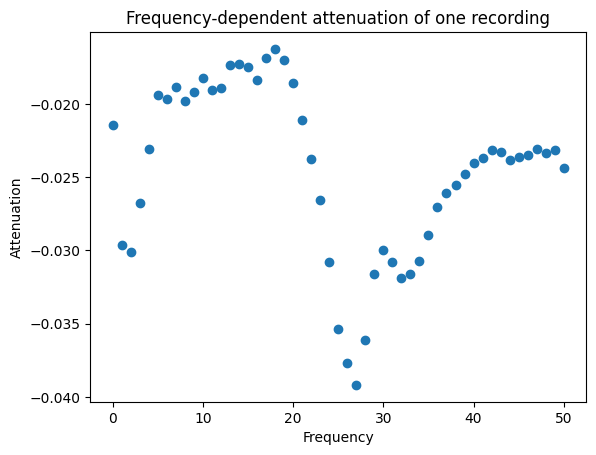

In [35]:
# average the scanlines of each recording
averaged_over_scanlines = []
for recording in range(len(slopes_all_recordings)):
    averaged_over_scanlines.append(np.mean(slopes_all_recordings[recording], axis = 0))
averaged_over_scanlines = np.array(averaged_over_scanlines)

# plot the frequency-dependent attenuation of one recording
plt.figure()
plt.scatter(np.arange(len(averaged_over_scanlines[0])),averaged_over_scanlines[0], label = 'Recording 1')
plt.xlabel('Frequency')
plt.ylabel('Attenuation')
plt.title('Frequency-dependent attenuation of one recording')
plt.show()

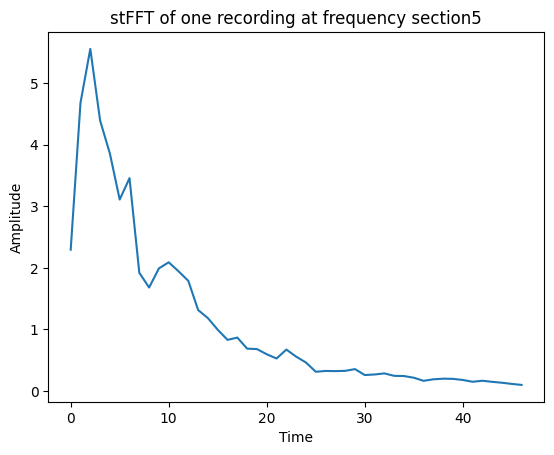

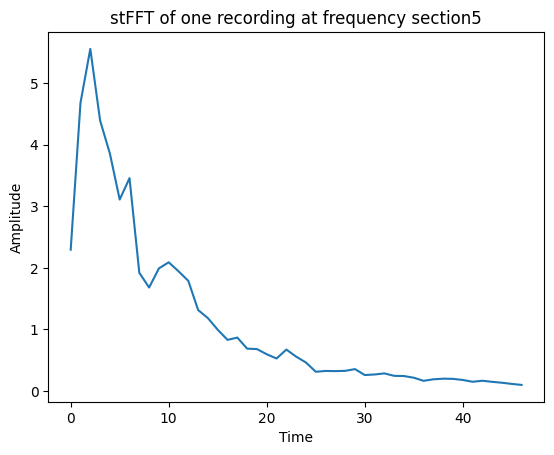

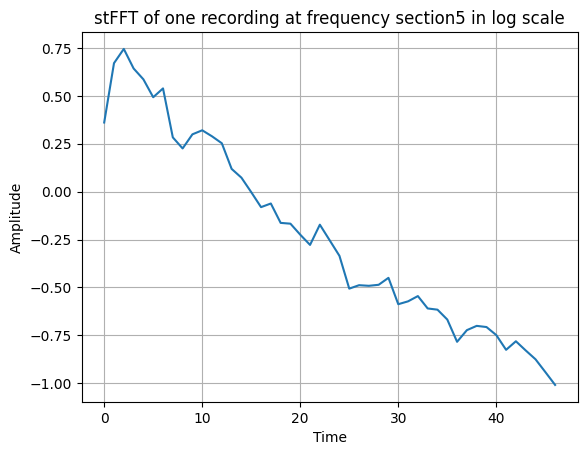

Slope of stFFT of one recording at frequency section 5 in log scale:  -0.03572718646598477


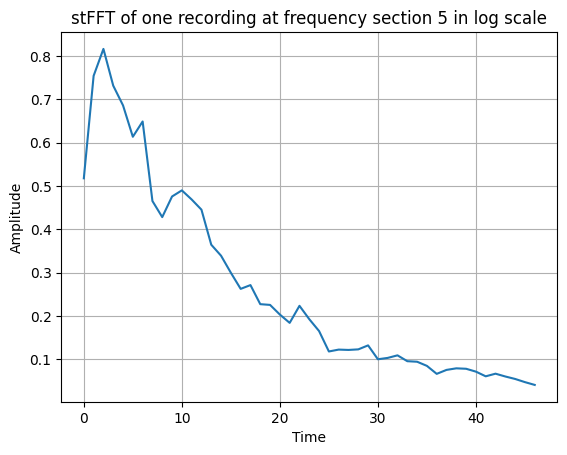

Slope of stFFT of one recording at frequency section 5 in log scale:  -0.014829330999982139


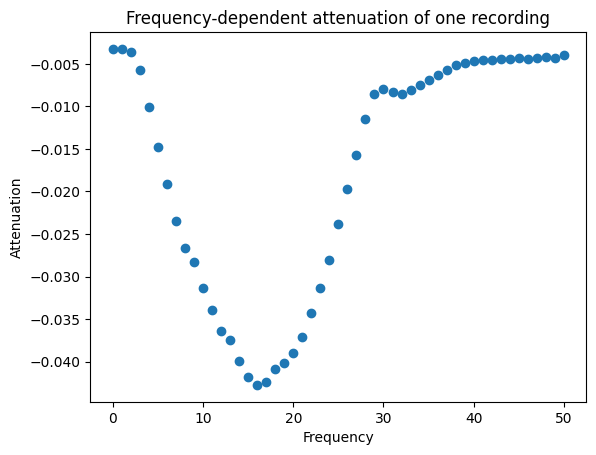

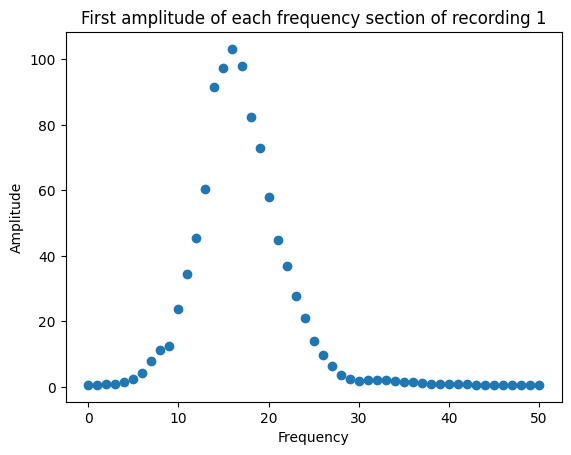

In [73]:
# get stfft of one recording
stfft_0 = stfft_all_recordings[0]

# average stfft_0 over scanlines
stfft_0_averaged_over_scanlines = np.mean(stfft_0, axis = 0)

frequency_section_1 = 5
frequency_section_2 = 5

# plot stfft_0_averaged_over_scanlines at frequency_section_1
plt.figure()
plt.plot(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_1])),stfft_0_averaged_over_scanlines[:,frequency_section_1], label = 'Recording 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('stFFT of one recording at frequency section'+str(frequency_section_1))
plt.show()

# plot stfft_0_averaged_over_scanlines at frequency_section_2
plt.figure()
plt.plot(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_2])),stfft_0_averaged_over_scanlines[:,frequency_section_2], label = 'Recording 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('stFFT of one recording at frequency section'+str(frequency_section_2))
plt.show()

# plot stfft_0_averaged_over_scanlines at frequency_section_1 in log scale
plt.figure()
plt.plot(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_1])),np.log10(stfft_0_averaged_over_scanlines[:,frequency_section_1]), label = 'Recording 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('stFFT of one recording at frequency section'+str(frequency_section_1)+' in log scale')
plt.grid()
plt.show()
# slope of stFFT of one recording at frequency_section_1 in log scale
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_1])), np.log10(stfft_0_averaged_over_scanlines[:,frequency_section_1]))
print('Slope of stFFT of one recording at frequency section '+str(frequency_section_1)+' in log scale: ', slope)

# plot stfft_0_averaged_over_scanlines at frequency_section_2 in log scale
plt.figure()
plt.plot(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_2])),np.log10(stfft_0_averaged_over_scanlines[:,frequency_section_2]+1), label = 'Recording 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('stFFT of one recording at frequency section '+str(frequency_section_2)+' in log scale')
plt.grid()
plt.show()
# slope of stFFT of one recording at frequency_section_2 in log scale
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(stfft_0_averaged_over_scanlines[:,frequency_section_2])), np.log10(stfft_0_averaged_over_scanlines[:,frequency_section_2]+1))
print('Slope of stFFT of one recording at frequency section '+str(frequency_section_2)+' in log scale: ', slope)

# calculate the slope for each frequency section of recording 1
slopes_per_frequency_section = []
for frequency_section in range(len(stfft_0_averaged_over_scanlines[0,:])):
    # bring stFFT to log scale (to get linear regression)
    # log10_stfft_0_averaged_over_scanlines = np.log10(stfft_0_averaged_over_scanlines[:,frequency_section]+1e-10)
    # # remove nan values
    # log10_stfft_0_averaged_over_scanlines = np.nan_to_num(log10_stfft_0_averaged_over_scanlines)
    log10_stfft_0_averaged_over_scanlines = np.log10(stfft_0_averaged_over_scanlines[:,frequency_section]+1)
    # get slope of stFFT
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(log10_stfft_0_averaged_over_scanlines)), log10_stfft_0_averaged_over_scanlines)
    slopes_per_frequency_section.append(slope)

slopes_per_frequency_section = np.array(slopes_per_frequency_section)

# plot the frequency-dependent attenuation of one recording
plt.figure()
plt.scatter(np.arange(len(slopes_per_frequency_section)),slopes_per_frequency_section, label = 'Recording 1')
plt.xlabel('Frequency')
plt.ylabel('Attenuation')
plt.title('Frequency-dependent attenuation of one recording')
plt.show()

# plot first amplitude of each frequency section of recording 1
plt.figure()
plt.scatter(np.arange(len(stfft_0_averaged_over_scanlines[0,:])),stfft_0_averaged_over_scanlines[0,:], label = 'Recording 1')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('First amplitude of each frequency section of recording 1')
plt.show()



In [83]:
# calculate mean slope value for all scanlines of one frequency of one recording
mean_slopes_all_recordings_freq = []
for recording in range(len(slopes_all_recordings)):
    mean_slope_per_frequency = []
    for frequency in range(len(slopes_all_recordings[recording,0,:])):
        mean_slope_per_frequency.append(np.mean(slopes_all_recordings[recording,:,frequency]))
    mean_slopes_all_recordings_freq.append(mean_slope_per_frequency)
mean_slopes_all_recordings_freq = np.array(mean_slopes_all_recordings_freq)


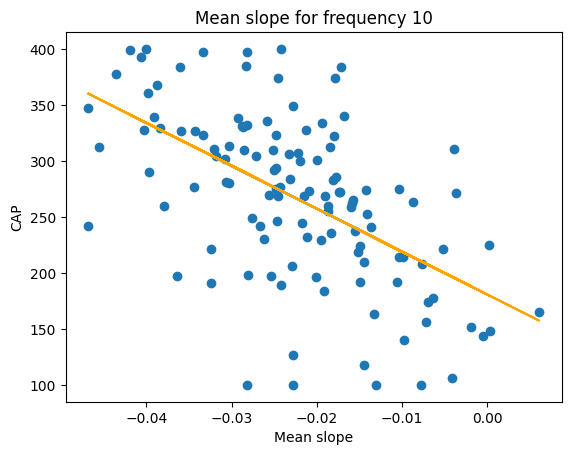

Pearson correlation coefficient:  -0.5651170546468415
Slope regression line:  -3832.89380321732


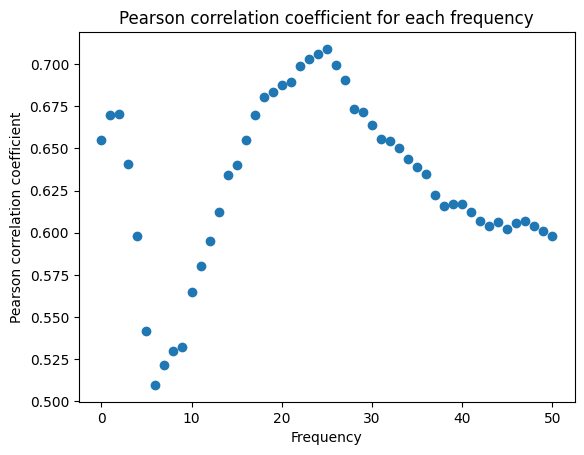

Best pearson correlation coefficient:  0.7089176844903113


0

In [84]:
# plot mean slopes all recordings for frequency 10
# calculate linear regression
slope, intercept, r, p, std_err = stats.linregress(mean_slopes_all_recordings_freq[:,10], redcap_value)
# define regression line
def myfunc(x):
    return slope * x + intercept
mymodel = list(map(myfunc, mean_slopes_all_recordings_freq[:,10]))


plt.figure()
plt.scatter(mean_slopes_all_recordings_freq[:,10], redcap_value)
# plot regression line
plt.plot(mean_slopes_all_recordings_freq[:,10], mymodel, color = 'orange')
plt.xlabel('Mean slope')
plt.ylabel('CAP')
plt.title('Mean slope for frequency 10')
plt.show()

print('Pearson correlation coefficient: ', r)
print('Slope regression line: ', slope)


# calculate linear regression for each frequency
pearson_per_frequency = []
for frequency in range(len(mean_slopes_all_recordings_freq[0,:])):
    slope, intercept, r, p, std_err = stats.linregress(mean_slopes_all_recordings_freq[:,frequency], redcap_value)
    pearson_per_frequency.append(np.abs(r))
pearson_per_frequency = np.array(pearson_per_frequency)

# plot pearson correlation coefficient for each frequency
plt.figure()
plt.scatter(np.arange(len(pearson_per_frequency)), pearson_per_frequency)
plt.xlabel('Frequency')
plt.ylabel('Pearson correlation coefficient')
plt.title('Pearson correlation coefficient for each frequency')
plt.show()

print('Best pearson correlation coefficient: ', np.max(pearson_per_frequency))

os.system('say "Berechnung abgeschlossen"')


In [ ]:
# export slopes and redcap values to use in AI application

# calculate mean slope value for all scanlines of one frequency of one recording
mean_slopes_all_recordings_freq = []
for recording in range(len(slopes_all_recordings)):
    mean_slope_per_frequency = []
    for frequency in range(len(slopes_all_recordings[recording,0,:])):
        mean_slope_per_frequency.append(np.mean(slopes_all_recordings[recording,:,frequency]))
    mean_slopes_all_recordings_freq.append(mean_slope_per_frequency)
mean_slopes_all_recordings_freq = np.array(mean_slopes_all_recordings_freq)

target_dict = {}
for key in patient_id_list:
    for value in redcap_value:
        target_dict[key] = value
        redcap_value.remove(value)
        break

# safe mean slopes and redcap values in AI directory
input_data_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data'
target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets' 
np.save(input_data_directory+'/mean_slopes_all_recordings_freqspec_'+transducer+'_'+version, mean_slopes_all_recordings_freq)
np.save(target_directory+'/targets_'+ref_parameter+'_freqspec_'+transducer+'_'+version, target_dict)


In [24]:
transducer = 'L15'
version = '230330'
if transducer == 'C3':
    fs = 15e6
elif transducer == 'L15':
    fs = 30e6
safe_to_notion = False

Best pearson correlation coefficient:  0.6930575580083522
Corresponding frequency:  3.75  ±  0.074  MHz
Number of used recordings:  121
Mean slope value:  -0.11058914749033778
Standard deviation slope value:  0.0138809775079319
Pearson coefficient over frequency: 


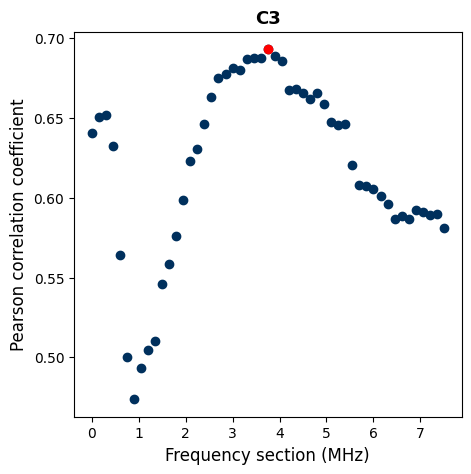

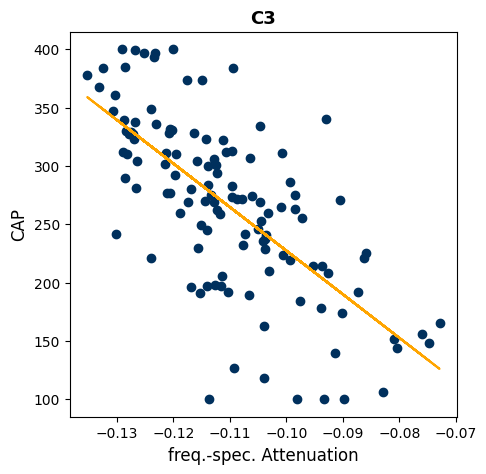

In [9]:
# calculate mean slope value for all scanlines of one frequency of one recording, plot results and safe to notion
data_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data'
target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets'

pearson_per_frequency, attenuation_values_best_freq, redcap_value,best_slope, best_intercept, best_r_value, best_p_value, best_mymodel = definitions.get_attenuation_best_freq(transducer, version, data_directory, target_directory)

# change frequency sections to actual frequencies
frequency_sections = np.arange(len(pearson_per_frequency))
best_frequency_section = frequency_sections[np.argmax(np.abs(pearson_per_frequency))]
real_frequency_sections = frequency_sections*fs/(window_size)/1e6
best_real_frequency = real_frequency_sections[np.argmax(np.abs(pearson_per_frequency))]

# print best pearson coefficient and corresponding frequency
print('Best pearson correlation coefficient: ', np.max(np.abs(pearson_per_frequency)))
print('Corresponding frequency: ', best_real_frequency, ' ± ',round(max(real_frequency_sections)/len(real_frequency_sections)/2, 3), ' MHz')
print('Number of used recordings: ', len(redcap_value))

# define distributions for best frequency section
mean_slope_per_frequency = np.mean(attenuation_values_best_freq)
std_slope_per_frequency = np.std(attenuation_values_best_freq)

print('Mean slope value: ', mean_slope_per_frequency)
print('Standard deviation slope value: ', std_slope_per_frequency)


# plot results
print('Pearson coefficient over frequency: ')
plt.figure(figsize = (5,5))
plt.scatter(real_frequency_sections,np.abs(pearson_per_frequency), color = '#00305D')
# mark best frequency section
plt.scatter(real_frequency_sections[best_frequency_section],np.abs(pearson_per_frequency[best_frequency_section]), color = '#FF0000')
plt.xlabel('Frequency section (MHz)', fontsize = 12)
plt.ylabel('Pearson correlation coefficient', fontsize = 12)
plt.title(transducer, fontweight = 'bold', fontsize = 13) #'Pearson coefficient over corresponding frequency'
plt.show()

# plot regression of best frequency section
plt.figure(figsize = (5,5))
plt.scatter( attenuation_values_best_freq,redcap_value, color = '#00305D')
plt.plot( attenuation_values_best_freq,best_mymodel, color = 'orange')
plt.ylabel(ref_parameter, fontsize = 12)
plt.xlabel('freq.-spec. Attenuation', fontsize = 12)
plt.title(transducer, fontweight = 'bold', fontsize = 13) #'Regression of best frequency section'
plt.show()

# safe to notion
notion_evaluation_parameter = 'freq-spec. Attenuation Parameter' 
notion_results = str('Best Pearson coef.: '+str(round(np.max(np.abs(pearson_per_frequency)), 3))+ '\n(Corresponding frequency: '+str(round(best_real_frequency, 3))+' MHz)')
notion_version = str(version+'\n('+str(len(redcap_value))+' Pat.)')
notion_def.safe_to_notion_def(notion_version, notion_evaluation_parameter, notion_results, notion_transducer, notion_cropping_properties,notion_window_func, safe_to_notion, results_database_id)

#os.system('say "Berechnung abgeschlossen"')    

Best spearman correlation coefficient:  0.7345026202061183
Corresponding frequency:  15.0  ±  0.147  MHz
Spearman coefficient over frequency: 


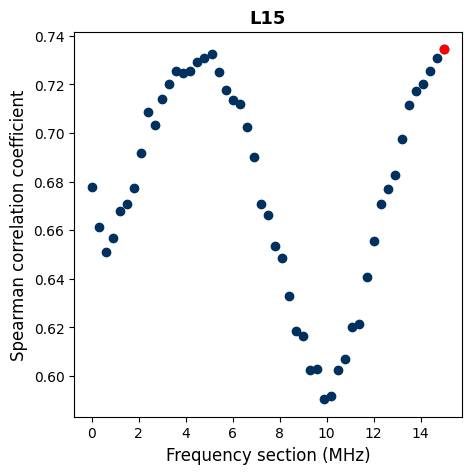

In [25]:
# perform spearman correlation
# load data 
version = '230330'
input_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data/'
file_path = input_directory+'mean_slopes_all_recordings_freqspec_'+transducer+'_'+version+'.npy'
mean_slopes_all_recordings_freq = np.load(file_path, allow_pickle='True')

target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets/'
target_path = target_directory+'targets_CAP_freqspec_'+transducer+'_'+version+'.npy'
target_dict = np.load(target_path, allow_pickle='True')
redcap_value = list(target_dict.item().values())

# calculate spearman correlation coefficient for each frequency
spearman_per_frequency = []
p_value_per_frequency = []
for frequency in range(len(mean_slopes_all_recordings_freq[0,:])):
    spearman, p_value = stats.spearmanr(mean_slopes_all_recordings_freq[:,frequency], redcap_value)
    spearman_per_frequency.append(np.abs(spearman))
    p_value_per_frequency.append(p_value)
spearman_per_frequency = np.array(spearman_per_frequency)

# change frequency sections to actual frequencies
frequency_sections = np.arange(len(spearman_per_frequency))
best_frequency_section = frequency_sections[np.argmax(np.abs(spearman_per_frequency))]
real_frequency_sections = frequency_sections*fs/(window_size)/1e6
best_real_frequency = real_frequency_sections[np.argmax(np.abs(spearman_per_frequency))]

# print results
print('Best spearman correlation coefficient: ', np.max(spearman_per_frequency))
print('P-Value of best spearman correlation coefficient: ', p_value_per_frequency[np.argmax(np.abs(spearman_per_frequency))])
print('Corresponding frequency: ', best_real_frequency, ' ± ',round(max(real_frequency_sections)/len(real_frequency_sections)/2, 3), ' MHz')

# plot spearman correlation coefficient for each frequency
print('Spearman coefficient over frequency: ')
plt.figure(figsize = (5,5))
plt.scatter(real_frequency_sections,np.abs(spearman_per_frequency), color = '#00305D')
# mark best frequency section
plt.scatter(real_frequency_sections[best_frequency_section],np.abs(spearman_per_frequency[best_frequency_section]), color = '#FF0000')
plt.xlabel('Frequency section (MHz)', fontsize = 12)
plt.ylabel('Spearman correlation coefficient', fontsize = 12)
plt.title(transducer, fontweight = 'bold', fontsize = 13) #'Spearman coefficient over corresponding frequency'
plt.show()



In [11]:
worst_frequency_section = frequency_sections[np.argmin(np.abs(pearson_per_frequency))]
worst_real_frequency = real_frequency_sections[np.argmin(np.abs(pearson_per_frequency))]
print('Worst pearson correlation coefficient: ', np.min(np.abs(pearson_per_frequency)))
print('Corresponding frequency: ', worst_real_frequency, ' ± ',round(max(real_frequency_sections)/len(real_frequency_sections)/2, 3), ' MHz')

Worst pearson correlation coefficient:  0.47372150152062936
Corresponding frequency:  0.9  ±  0.074  MHz


In [ ]:
# boxplots for freq. spec. Attenuation

data_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Input_data'
target_directory = '/Users/jakobschaefer/Documents/RF_US_AI/MLP_QUS_Parameter/Targets'


pearson_per_frequency_C3, attenuation_values_best_freq_C3, redcap_value_C3, best_slope_C3, best_intercept_C3, best_r_value_C3, best_p_value_C3, best_mymodel_C3 = definitions.get_attenuation_best_freq('C3',version, data_directory, target_directory)
pearson_per_frequency_L15, attenuation_values_best_freq_L15, redcap_value_L15, best_slope_L15, best_intercept_L15, best_r_value_L15, best_p_value_L15, best_mymodel_L15 = definitions.get_attenuation_best_freq('L15',version, data_directory, target_directory)

target_dict_C3 = np.load(target_directory+'/targets_CAP_freqspec_'+'C3'+'_'+version+'.npy', allow_pickle='TRUE').item()
target_dict_L15 = np.load(target_directory+'/targets_CAP_freqspec_'+'L15'+'_'+version+'.npy', allow_pickle='TRUE').item()

patient_id_C3 = list(target_dict_C3.keys())
patient_id_L15 = list(target_dict_L15.keys())

removal_based_on = 'IQR' # 'IQR' or 'std'
threshold = 'higher' # 'lower' -> IQR-quartiles at 25% and 75% and 2*std, 'higher' -> IQR-quartiles at 5% and 95% and 3*std


# list outliers
# C3 
evaluation_parameters_no_outliers_C3, redcap_value_outlier_removal_C3, n_outliers_C3, id_outliers_C3 = definitions.detect_and_remove_outliers(patient_id_C3, attenuation_values_best_freq_C3,redcap_value_C3, removal_based_on, threshold)
# L15
evaluation_parameters_no_outliers_L15, redcap_value_outlier_removal_L15, n_outliers_L15, id_outliers_L15 = definitions.detect_and_remove_outliers(patient_id_L15, attenuation_values_best_freq_L15,redcap_value_L15, removal_based_on, threshold)

print('Outliers C3: ', n_outliers_C3, '(IDs: ', id_outliers_C3, ')')
print('Outliers L15: ', n_outliers_L15, '(IDs: ', id_outliers_L15, ')')

# plot boxplots for C3 and L15 frequency-specific Attenuation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# boxplot C3
plt.sca(ax[0])
plt.boxplot(attenuation_values_best_freq_C3)
plt.title('C3 Attenuation Regression', fontsize=12, fontweight='bold')
plt.ylabel('Attenuation', fontsize=12)
plt.xticks([])
#plt.xlabel('C3')

# boxplot L15
plt.sca(ax[1])
plt.boxplot(attenuation_values_best_freq_L15)
plt.title('L15 Attenuation Regression', fontsize=12, fontweight='bold')
plt.ylabel('Attenuation', fontsize=12)
plt.xticks([])
#plt.xlabel('L15')

fig.tight_layout()
plt.show()




In [ ]:
# plot frequency specific pearson coefficient divided by amplitude of this frequency -> to see if the correlation is frequency dependent or amplitude dependent

# calculate FFT for all recordings
fft_all_recordings = []
for recording in tqdm(os.listdir(start_directory)):
    # load file
    array = np.load(start_directory+'/'+recording+'/'+transducer+'_large.rf_no_tgc.npy')

    # sort out recordings where array is shorter than a certain length
    if len(array[0,:,0]) >= 2704:
       

        # get sampling rate out of yaml file
        if transducer == 'C3':
            yaml_file = start_directory+'/'+dir+'/'+transducer+'_large.rf.yaml'
            sampling_rate, t = definitions.read_yaml_file(yaml_file, array)
        else:
            yaml_file = start_directory+'/'+dir+'/'+'L15'+'_large.rf.yaml'
            sampling_rate, t = definitions.read_yaml_file(yaml_file, array)

        # perform FFT on first scanline in first frame
        x_fft,y_fft = definitions.amplitude_spectrum(sampling_rate, array[0,:,0], window_function)

        # append FFT to list
        fft_all_recordings.append(y_fft)
fft_all_recordings = np.array(fft_all_recordings)

In [ ]:
# calculate mean FFT of all recordings
mean_fft_all_recordings_stfft = np.mean(np.abs(stfft_all_recordings), axis=(0,1,2))

mean_fft_all_recordings_2 = np.mean(np.abs(fft_all_recordings), axis=0)
# reduce mean_fft_all_recordings to the same length as mean_fft_all_recordings_stfft
quotient = int(len(mean_fft_all_recordings_2)/len(mean_fft_all_recordings_stfft))

shortened_mean_fft_all_recordings_2 = np.zeros(len(mean_fft_all_recordings_stfft))
done = 0
for step in range(len(mean_fft_all_recordings_stfft)):
    shortened_mean_fft_all_recordings_2[step] = np.mean(mean_fft_all_recordings_2[done:done+quotient])
    done = done + quotient


# plot mean_fft_all_recordings_2:
plt.figure()
plt.plot(x_fft, mean_fft_all_recordings_2, color = '#00305D')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
#plt.title('Mean FFT of all recordings')


fig, ax1 = plt.subplots()
# plot pearson coefficients
color_ax1 = '#00305D'
ax1.scatter(real_frequency_sections,np.abs(pearson_per_frequency), label = 'Pearson coefficient', color = color_ax1)
ax1.set_xlabel('Frequency section (MHz)')
ax1.set_ylabel('Pearson correlation coefficient', color = color_ax1)
#plt.title('Pearson value over corresponding frequency')

ax2 = ax1.twinx()

# plot mean_fft_all_recordings
color_ax2 = '#FF0000'
ax2.plot(real_frequency_sections, mean_fft_all_recordings_stfft,  label = 'mean FFT of all recordings', color = color_ax2)
ax2.set_ylabel('Amplitude', color = color_ax2)
plt.legend()
#plt.title('Mean FFT of all recordings')


pearson_per_frequency_divided_by_amplitude = np.array(np.abs(pearson_per_frequency))/mean_fft_all_recordings_stfft


plt.figure()
plt.scatter(real_frequency_sections,np.abs(pearson_per_frequency_divided_by_amplitude), color = '#00305D')
plt.xlabel('Frequency section (MHz)')
plt.ylabel('Pearson correlation coefficient divided by amplitude')
plt.title('Amplitude-corrected pearson value over corresponding frequency')
plt.show()

In [ ]:
print(mean_fft_all_recordings.shape)
print(mean_fft_all_recordings_2.shape)

# reduce mean_fft_all_recordings_2 to the same length as mean_fft_all_recordings
quotient = int(len(mean_fft_all_recordings_2)/len(mean_fft_all_recordings))

shortened_mean_fft_all_recordings_2 = np.zeros(len(mean_fft_all_recordings))
done = 0
for step in range(len(mean_fft_all_recordings)):
    shortened_mean_fft_all_recordings_2[step] = np.mean(mean_fft_all_recordings_2[done:done+quotient])
    done = done + quotient



print(mean_fft_all_recordings.shape)
print( mean_fft_all_recordings.shape)

# plot
plt.figure()
plt.plot(real_frequency_sections, mean_fft_all_recordings, label = 'mean FFT of all recordings')
plt.plot(real_frequency_sections, shortened_mean_fft_all_recordings_2, label = 'mean FFT of all recordings 2')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('Mean FFT of all recordings')
plt.legend()
plt.show()


In [ ]:
# save results for AI evaluation
np.save('/Users/jakobschaefer/Documents/local_GitProjects/RF_US_AI/MLP/Data/'+version+'_'+transducer+'_mean_slopes_all_recordings.npy', mean_slopes_all_recordings)
np.save('/Users/jakobschaefer/Documents/local_GitProjects/RF_US_AI/MLP/Targets/'+version+'_'+transducer+'_redcap_value.npy', normalized_stfft_all_recordings)

In [ ]:
mean_slopes_best_frequency = np.abs(np.array(mean_slopes_all_recordings)[:,frequency])

model = np.polyfit(mean_slopes_best_frequency, redcap_value, 1)
predict = np.poly1d(model)
x_lin_reg = np.linspace(np.min(mean_slopes_best_frequency), np.max(mean_slopes_best_frequency), 100)
y_lin_reg = predict(x_lin_reg)

r_squared = r2_score(redcap_value, predict(mean_slopes_best_frequency))

print('R^2: ', r_squared)
print('R: ', np.sqrt(r_squared))
plt.figure(figsize = (12,5))
plt.scatter(mean_slopes_best_frequency,redcap_value, color = '#00305D')
plt.plot(x_lin_reg, y_lin_reg, color = 'orange')
plt.xlabel('RF-based attenuation')
plt.ylabel(ref_parameter)
# plt.title('Correlation between CAP value and RF-based attenuation at '+str(best_real_frequency)+' MHz')
plt.show()

In [ ]:
print(np.min(mean_slopes_best_frequency), np.max(mean_slopes_best_frequency))

model

In [ ]:
# plot pearson over CAP for best frequency
best_frequency_section = frequency_sections[np.argmax(np.abs(pearson_per_frequency))]
slope, intercept, r_value, p_value, std_err = stats.linregress(redcap_value, np.array(mean_slopes_all_recordings)[:,best_frequency_section])

def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, redcap_value))

print('Pearson coefficient over CAP value: ', r_value)

plt.figure()
plt.scatter(redcap_value,mean_slopes_all_recordings[:,best_frequency_section], c = scan_conditions_list)
plt.plot(redcap_value, mymodel, color = 'orange')
plt.xlabel(ref_parameter)
plt.ylabel('RF-based attenuation')
plt.title('Correlation between CAP value and rf-based attenuation at: '+ str(best_real_frequency)+ ' MHz')
plt.show()

# exclude bad conditions (scan_conditions_list = 3)
new_scan_conditions_list = copy.deepcopy(scan_conditions_list)
list(new_scan_conditions_list)
new_mean_slopes_all_recordings = copy.deepcopy(mean_slopes_all_recordings)
new_redcap_value = copy.deepcopy(redcap_value)

for element in new_scan_conditions_list:
  if element == 3.0:
    index = new_scan_conditions_list.index(element)
    new_scan_conditions_list = np.delete(new_scan_conditions_list, index)
    new_mean_slopes_all_recordings = np.delete(new_mean_slopes_all_recordings, index, axis = 0)
    new_redcap_value = np.delete(new_redcap_value, index)

  
best_frequency_section = frequency_sections[np.argmax(np.abs(pearson_per_frequency))]
slope, intercept, r_value, p_value, std_err = stats.linregress(new_redcap_value, np.array(new_mean_slopes_all_recordings)[:,best_frequency_section])

def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, new_redcap_value))

print('Pearson coefficient over CAP value: ', r_value)

plt.figure()
plt.scatter(new_redcap_value,new_mean_slopes_all_recordings[:,best_frequency_section], c = new_scan_conditions_list)
plt.plot(new_redcap_value, mymodel, color = 'orange')
plt.xlabel(ref_parameter)
plt.ylabel('RF-based attenuation')
plt.title('Correlation between CAP value and rf-based attenuation at: '+ str(best_real_frequency)+ ' MHz')
plt.show()

In [ ]:
something = np.max(new_mean_slopes_all_recordings[:,best_frequency_section])

print(something)

In [ ]:
for element in redcap_value:
    if element == 100:
        index = redcap_value.index(element)
        print('100: ', mean_slopes_all_recordings[index,best_frequency_section])
        print(scan_conditions_list[index])
